# Model Training

### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [626]:
#Importing Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

##### Importing Modelling Libraries

In [627]:
#Modeling Import
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

#### Importing CSV data as Pandas dataframe

In [628]:
df = pd.read_csv('data/DWSIM.csv')

In [629]:
#Shows top 5 records
df.head()

,Reflux Ratio (R),Boilup Ratio (B),Feed Mole Fraction (xF),Feed Flowrate (F) kmol/hr,Number of Stages (N),Feed Thermal Condition (q),Distillate Mole Fraction (xD),Reboiler Duty (QR) (kW)
0,3.89,1.66,0.21,74.18,25,1,0.806,2742
1,4.54,1.36,0.67,80.39,25,1,0.853,2637
2,3.56,2.58,0.61,86.30,25,1,0.848,3062
3,4.43,1.69,0.81,71.26,25,0,0.884,2722
4,2.69,2.17,0.45,99.56,20,1,0.820,3231


In [630]:
#Shape of the dataset
df.shape

(373, 8)

#### Missing Values

In [631]:
#checks for missing values
df.isna().sum()

Reflux Ratio (R)                 0
Boilup Ratio (B)                 0
Feed Mole Fraction (xF)          0
Feed Flowrate (F) kmol/hr        0
Number of Stages (N)             0
Feed Thermal Condition (q)       0
Distillate Mole Fraction (xD)    0
Reboiler Duty (QR) (kW)          0
dtype: int64

In [632]:
if 'Distillate_MoleFraction' in df.columns:
    df = df[(df['Distillate_MoleFraction'] >= 0) & (df['Distillate_MoleFraction'] <= 1)]

if 'ReboilerDuty' in df.columns:
    df = df[df['ReboilerDuty'] >= 0]

df = df.dropna()
print("Dataset after removing failed runs:", df.shape)

Dataset after removing failed runs: (373, 8)


#### Duplicate Value

In [633]:
#Checks for duplicates
df.duplicated().sum()

np.int64(66)

In [634]:
#Deletes duplicates
df = df.drop_duplicates()

In [635]:
df.shape

(307, 8)

#### Rename Columns

In [636]:
#Renaming columns for better accessibility
df.rename(columns={
    'Reflux Ratio (R)': 'RefluxRatio',
    'Boilup Ratio (B)': 'BoilupRatio',
    'Feed Mole Fraction (xF)': 'Feed_MoleFraction',
    'Feed Flowrate (F) kmol/hr': 'Feed_Flowrate',
    'Number of Stages (N)': 'Stages',
    'Feed Thermal Condition (q)': 'Feed_ThermalCondition',
    'Distillate Mole Fraction (xD)': 'Distillate_MoleFraction',
    'Reboiler Duty (QR) (kW)': 'ReboilerDuty'
}, inplace=True)
df.head()

,RefluxRatio,BoilupRatio,Feed_MoleFraction,Feed_Flowrate,Stages,Feed_ThermalCondition,Distillate_MoleFraction,ReboilerDuty
0,3.89,1.66,0.21,74.18,25,1,0.806,2742
1,4.54,1.36,0.67,80.39,25,1,0.853,2637
2,3.56,2.58,0.61,86.30,25,1,0.848,3062
3,4.43,1.69,0.81,71.26,25,0,0.884,2722
4,2.69,2.17,0.45,99.56,20,1,0.820,3231


#### Unit Consistency Check

In [637]:
if "Feed_Flowrate" in df.columns:
    print("Feed Flowrate (kmol/h):", df["Feed_Flowrate"].min(), "to", df["Feed_Flowrate"].max())

if "ReboilerDuty" in df.columns:
    print("Reboiler Duty (kW):", df["ReboilerDuty"].min(), "to", df["ReboilerDuty"].max())

Feed Flowrate (kmol/h): 71.26 to 134.65
Reboiler Duty (kW): 2549 to 3350


In [638]:
#Physical Consistency Checks
print("Before unit consistency check:", df.shape)
# Distillate mole fraction must be between 0 and 1
df = df[(df['Distillate_MoleFraction'] >= 0) & (df['Distillate_MoleFraction'] <= 1)]

# Reflux ratio (R): 0.8 – 5.0
df = df[(df['RefluxRatio'] >= 0.8) & (df['RefluxRatio'] <= 5.0)]

# Boilup ratio (B): keep >0, assume upper limit 10
df = df[(df['BoilupRatio'] > 0) & (df['BoilupRatio'] <= 10)]

# Feed mole fraction of light key (xF): 0.2 – 0.95
df = df[(df['Feed_MoleFraction'] >= 0.2) & (df['Feed_MoleFraction'] <= 0.95)]

# Feed flowrate (F): vary ±30% around base
if 'Feed_Flowrate' in df.columns:
    F0 = df['Feed_Flowrate'].mean()  
    df = df[(df['Feed_Flowrate'] >= 0.7 * F0) & (df['Feed_Flowrate'] <= 1.3 * F0)]

# Number of stages (N): discrete values ( 15, 20, 25)
if 'Stages' in df.columns:
    df = df[df['Stages'].isin([15, 20, 25])]

# Feed thermal condition (q): discrete categories
if 'Feed_ThermalComposition' in df.columns:
    df = df[(df['Feed_ThermalCondition'] >= 0) & (df['Feed_ThermalCondition'] <= 1)]

print("After unit consistency check:", df.shape)


Before unit consistency check: (307, 8)
After unit consistency check: (306, 8)


In [639]:
#Independent Features
X = df.drop(columns=['Distillate_MoleFraction','ReboilerDuty'])
X.head()

,RefluxRatio,BoilupRatio,Feed_MoleFraction,Feed_Flowrate,Stages,Feed_ThermalCondition
0,3.89,1.66,0.21,74.18,25,1
1,4.54,1.36,0.67,80.39,25,1
2,3.56,2.58,0.61,86.30,25,1
4,2.69,2.17,0.45,99.56,20,1
5,1.35,2.43,0.23,87.97,15,0


In [640]:
#Dependent Features
y = df[['Distillate_MoleFraction', 'ReboilerDuty']]

In [641]:
#Train Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.shape, X_test.shape

((214, 6), (46, 6))

In [642]:
# Define categorical and numerical feature columns
cat_features = ['Feed_ThermalCondition']
num_features = [col for col in X.columns if col not in cat_features]

numeric_transformer = StandardScaler()                     # Standardize numerical features
cat_transformer = OneHotEncoder()                          # OneHot encode categorical features

#Apply scaling to numeric features and encoding to categorical features
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", cat_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [643]:
#Apply transformations to the features
X_processed = preprocessor.fit_transform(X)

In [644]:
# Check shape before and after transformation
#5 numerical
#1 categorical
X.shape      


(306, 6)

In [645]:
#5 standardized numerical features
#1 categorical feature turned into 2 one-hot encoded columns
X_processed.shape

(306, 7)

In [646]:
models = {
    "Polynomial Regression": Pipeline([
        ('pre', preprocessor),
        ('poly', PolynomialFeatures(degree=3)),
        ('linreg', MultiOutputRegressor(LinearRegression()))
    ]),
    "Random Forest": Pipeline([
        ('pre', preprocessor),
        ('rf', MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42)))
    ]),
    "AdaBoost": Pipeline([
        ('pre', preprocessor),
        ('ada', MultiOutputRegressor(AdaBoostRegressor(random_state=42)))
    ]),
    "SVR": Pipeline([
        ('pre', preprocessor),
        ('svr', MultiOutputRegressor(SVR()))
    ]),
    "XGBoost": Pipeline([
        ('pre', preprocessor),
        ('xgb', MultiOutputRegressor(XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, verbosity=0)))
    ])
}


In [647]:
param_grids = {
    "Polynomial Regression": {
        'poly__degree': [2, 3, 4]  # polynomial degree
    },
    "Random Forest": {
        'rf__estimator__n_estimators': [100, 200, 300],
        'rf__estimator__max_depth': [None, 5, 10, 20],
        'rf__estimator__min_samples_split': [2, 5, 10],
        'rf__estimator__min_samples_leaf': [1, 2, 4]
    },
    "AdaBoost": {
        'ada__estimator__n_estimators': [50, 100, 200],
        'ada__estimator__learning_rate': [0.01, 0.1, 1.0]
    },
    "SVR": {
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__gamma': ['scale', 'auto'],
        'svr__estimator__kernel': ['rbf', 'poly', 'linear']
    },
    "XGBoost": {
        'xgb__estimator__n_estimators': [100, 200, 500],
        'xgb__estimator__max_depth': [3, 5, 7],
        'xgb__estimator__learning_rate': [0.01, 0.05, 0.1],
        'xgb__estimator__subsample': [0.7, 0.9, 1.0]
    }
}


In [ ]:

def tune_and_evaluate(models, param_grids, X_train, y_train, X_val, y_val, X_test, y_test, n_iter=10, cv=3):
#Tune hyperparameters via RandomizedSearchCV for each model and report metrics.
    results = {}

    for name, model in models.items():
        # Check if hyperparameter grid exists for this model
        if name in param_grids:
            search = RandomizedSearchCV(
                model,
                param_distributions=param_grids[name],
                n_iter=n_iter,
                scoring='r2',
                cv=cv,
                random_state=42,
                n_jobs=-1,
                verbose=1
            )
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            
        else:
            # If no grid, just fit the model directly
            best_model = model.fit(X_train, y_train)

        # --- Validation metrics ---
        y_val_pred = best_model.predict(X_val)
        mae_val = mean_absolute_error(y_val, y_val_pred)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        r2_val = r2_score(y_val, y_val_pred)

        # --- Test metrics ---
        y_test_pred = best_model.predict(X_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        r2_test = r2_score(y_test, y_test_pred)

        # Store results
        results[name] = {
            "Best Model": best_model,
            "Val MAE": mae_val,
            "Val RMSE": rmse_val,
            "Val R²": r2_val,
            "Test MAE": mae_test,
            "Test RMSE": rmse_test,
            "Test R²": r2_test
        }
    return results
results = tune_and_evaluate(models, param_grids, X_train, y_train, X_val, y_val, X_test, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [ ]:
# Convert results dict to simple DataFrame
metrics_table = pd.DataFrame([
    {
        "Model": name,
        "Val MAE": metrics["Val MAE"],
        "Val RMSE": metrics["Val RMSE"],
        "Val R²": metrics["Val R²"],
        "Test MAE": metrics["Test MAE"],
        "Test RMSE": metrics["Test RMSE"],
        "Test R²": metrics["Test R²"]
    }
    for name, metrics in results.items()
])


# Display the table
metrics_table


,Model,Val MAE,Val RMSE,Val R²,Test MAE,Test RMSE,Test R²
0,Polynomial Regression,31.205689,59.842572,0.773138,38.927603,79.972304,0.603202
1,Random Forest,16.029225,44.777417,0.899587,25.833033,63.460892,0.764457
2,AdaBoost,27.153505,56.080649,0.849201,34.443497,71.427358,0.725384
3,SVR,28.792548,57.830207,0.349886,35.763284,71.634928,0.228871
4,XGBoost,15.237474,39.812086,0.894503,22.526592,57.842100,0.786709


#### Physical Consistency Check 

In [ ]:
#Enforce Bounds
best_model = results["XGBoost"]["Best Model"]

y_test_pred = best_model.predict(X_test)

y_test_pred = pd.DataFrame(y_test_pred, columns=['Distillate_MoleFraction', 'ReboilerDuty'])
y_test_true = pd.DataFrame(y_test, columns=['Distillate_MoleFraction', 'ReboilerDuty'])

# --- 1. Bounds check: enforce 0 ≤ xD ≤ 1 ---
y_test_pred['Distillate_MoleFraction'] = y_test_pred['Distillate_MoleFraction'].clip(0, 1)

In [ ]:
#Monotonic sanity check
def monotonic_check(X, y_pred):
    violations = 0
    grouped = pd.concat([X.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
    for (xF, N), g in grouped.groupby(['Feed_MoleFraction', 'Stages']):
        g_sorted = g.sort_values('RefluxRatio')
        if (g_sorted['Distillate_MoleFraction'].diff().dropna() < -1e-3).any():
            violations += 1
    print(f"Monotonicity violations found: {violations}")

monotonic_check(X_test, y_test_pred)

Monotonicity violations found: 1


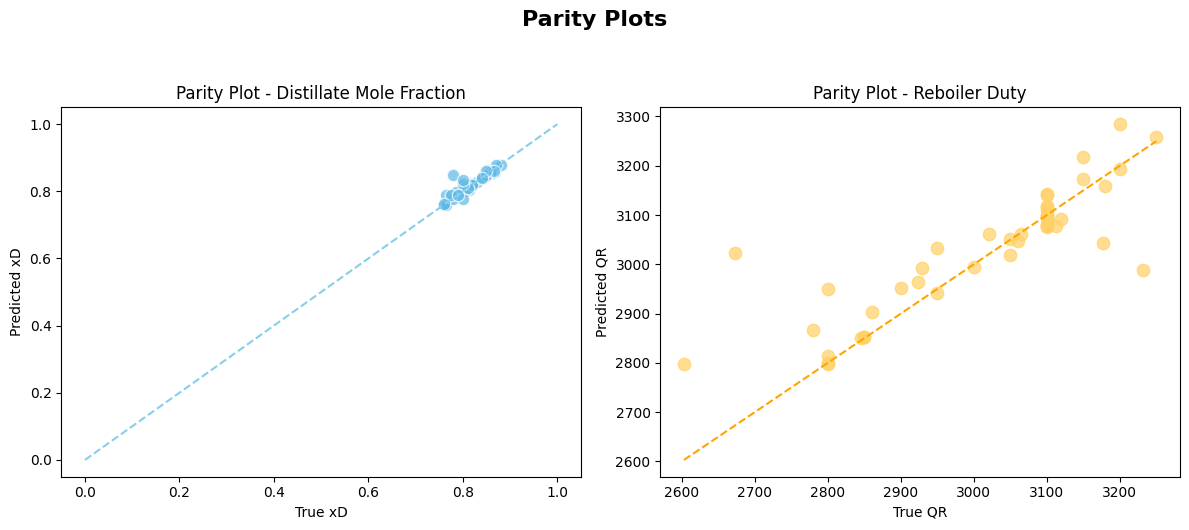

In [ ]:

if isinstance(y_test_pred, pd.DataFrame):
    y_test_pred = y_test_pred.values

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Parity Plots", fontsize=16, fontweight='bold', y=1.05)

# xD parity
axes[0].scatter(y_test['Distillate_MoleFraction'], y_test_pred[:, 0], s=80, alpha=0.7, color="#5CB8E6", edgecolor='w')
axes[0].plot([0, 1], [0, 1], '--', color='skyblue')
axes[0].set_xlabel("True xD")
axes[0].set_ylabel("Predicted xD")
axes[0].set_title("Parity Plot - Distillate Mole Fraction")

# QR parity
qr_min, qr_max = y_test['ReboilerDuty'].min(), y_test['ReboilerDuty'].max()
axes[1].scatter(y_test['ReboilerDuty'], y_test_pred[:, 1], s=80, alpha=0.7, color="#FFD166", edgecolor='#FFD166')
axes[1].plot([qr_min, qr_max], [qr_min, qr_max], '--', color='orange')
axes[1].set_xlabel("True QR")
axes[1].set_ylabel("Predicted QR")
axes[1].set_title("Parity Plot - Reboiler Duty")

plt.tight_layout()
plt.show()



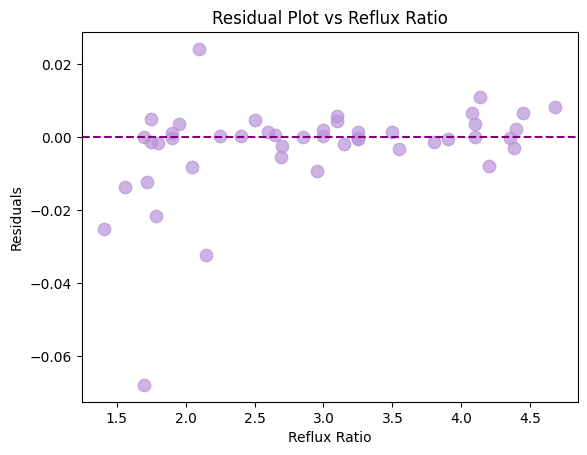

In [ ]:
residuals = y_test['Distillate_MoleFraction'] - y_test_pred[:,0]
plt.scatter(X_test['RefluxRatio'], residuals, s=80, alpha=0.7, c='#B894D9', edgecolor='#B894D9')
plt.axhline(0, color='purple', linestyle='--')
plt.xlabel("Reflux Ratio")
plt.ylabel("Residuals")
plt.title("Residual Plot vs Reflux Ratio")
plt.show()

In [ ]:
#Error slices: high purity region (xD ≥ 0.95)
mask_hp = y_test_true['Distillate_MoleFraction'] >= 0.95
if mask_hp.any():
    mae_hp = mean_absolute_error(y_test_true.loc[mask_hp, 'Distillate_MoleFraction'], y_test_pred.loc[mask_hp, 'Distillate_MoleFraction'])
    rmse_hp = np.sqrt(mean_squared_error(y_test_true.loc[mask_hp, 'Distillate_MoleFraction'], y_test_pred.loc[mask_hp, 'Distillate_MoleFraction']))
    r2_hp = r2_score(y_test_true.loc[mask_hp, 'Distillate_MoleFraction'], y_test_pred.loc[mask_hp, 'Distillate_MoleFraction'])
    print("High-purity region metrics (Distillate_MoleFraction ≥ 0.95):")
    print(f"  MAE  = {mae_hp:.4f}")
    print(f"  RMSE = {rmse_hp:.4f}")
    print(f"  R²   = {r2_hp:.4f}")
else:
    print("No samples in test set with Distillate_MoleFraction ≥ 0.95")

No samples in test set with Distillate_MoleFraction ≥ 0.95


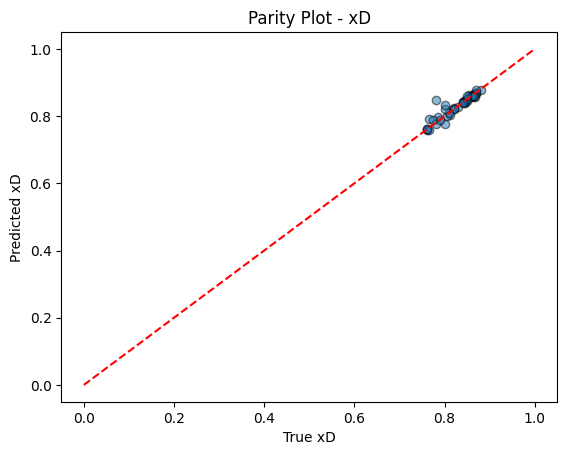

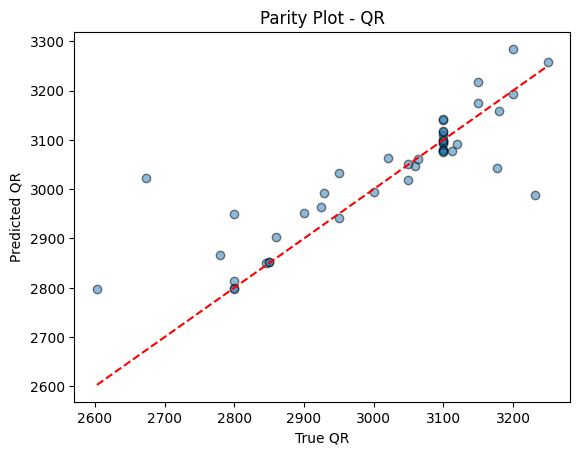

In [ ]:
# Parity plot for xD
if isinstance(y_test_pred, pd.DataFrame):
    y_test_pred = y_test_pred.values

plt.scatter(y_test['Distillate_MoleFraction'], y_test_pred[:, 0], alpha=0.5, edgecolor='k')
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel("True xD")
plt.ylabel("Predicted xD")
plt.title("Parity Plot - xD")
plt.show()

# Parity plot for QR
plt.scatter(y_test['ReboilerDuty'], y_test_pred[:, 1], alpha=0.5, edgecolor='k')
plt.plot([y_test['ReboilerDuty'].min(), y_test['ReboilerDuty'].max()],
         [y_test['ReboilerDuty'].min(), y_test['ReboilerDuty'].max()],
         '--', color='red')
plt.xlabel("True QR")
plt.ylabel("Predicted QR")
plt.title("Parity Plot - QR")
plt.show()


#### Generalisation Check

In [ ]:
metrics_table['Generalization Gap'] = metrics_table['Val R²'] - metrics_table['Test R²']
metrics_table[['Model','Val R²','Test R²','Generalization Gap']]

,Model,Val R²,Test R²,Generalization Gap
0,Polynomial Regression,0.773138,0.603202,0.169936
1,Random Forest,0.899587,0.764457,0.135130
2,AdaBoost,0.849201,0.725384,0.123817
3,SVR,0.349886,0.228871,0.121015
4,XGBoost,0.894503,0.786709,0.107794
